original Vph: 
 [178.56078151389613, 263.78954988955525, 300.49538338104327, 319.1437374243512, 330.19344986645723]
New layer set is:  [0, 6]
New layer set is:  [0, 6, inf]
[0, 6, inf]
             Layer 1   Layer 2
Table name                    
Lambda 1    0.886360  0.113640
Lambda 2    0.535105  0.464895


New array of shear wave velocity is:
 [162.75566398 424.30866639]


The diperion curve checked is:
 [178.5607815138962, 263.7895498895553, 306.2324753042093, 328.7562918210814, 342.35380281246523]


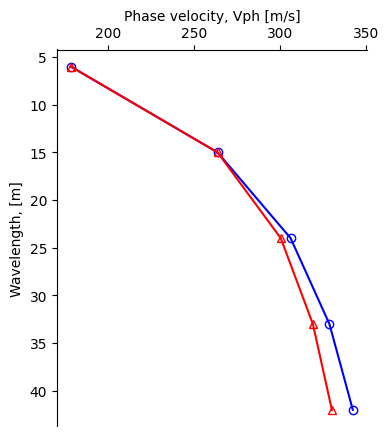

In [12]:
import numpy as np
import sympy as sp
import tkinter
import matplotlib.pyplot as plt
from pandas import *
# DISPERSION

PR = 0.3 # Poisson'a ratio
beta = (0.87+1.12*PR)/(1+PR)

Layer_Data = np.array([[150,5],
                       [400,np.inf]])
waveLength0 = 6
wavelengthMax = 44
deltaWaveLength = 9

Lambda = np.arange(waveLength0,wavelengthMax,deltaWaveLength)
def dataInput(soilProfile,desiredWavelength):
    numLayers = len(soilProfile[:,0])
    DC_points = len(desiredWavelength)
    Depth =np.append(0, soilProfile[:,1])
    Vs = soilProfile[:,0]
    return numLayers,Depth,Vs,DC_points
numLayers,Depth,Vs,DC_points = dataInput(Layer_Data,Lambda)

def plotTable(weightMatrix,index ='Lambda {}',columns='Layer {}',Name = 'Table name'):
    lambdaLabels = []
    layerLabels = []
    for i in range(len(weightMatrix[:,0])):
        lambdaLabels.append(index.format(i+1))
    for j in range(len(weightMatrix[0,:])):
        layerLabels.append(columns.format(j+1))
    df = DataFrame(weightMatrix,index=Index(lambdaLabels, name=Name),columns=layerLabels)
    df.style
    print(df)
# Function to compute weights

def weighting(D,WL):
    z = sp.symbols('z')
    material_coefficient = 1
    limit_low = D[:-1]
    limit_up = D[1:]
    cv = np.array([0.2507, -0.4341, -0.8474*2*np.pi, -0.3933*2*np.pi])
    cv1 = cv[0]
    cv2 = cv[1]
    cv3 = cv[2]
    cv4 = cv[3]
    # Particle displacement function
    PDF = (cv1*sp.exp(cv3/WL*z) + cv2*sp.exp(cv4/WL*z))*\
    material_coefficient
    # Loop to compute wave a the wavelength given
    num_layer = len(D) - 1
    Area_i = np.zeros((num_layer),dtype='object')
    # Total area
    A_term1 = (cv1/(cv3/WL))*(sp.exp(cv3/WL*np.inf) - sp.exp(cv3/WL*0))
    A_term2 = (cv2/(cv4/WL))*(sp.exp(cv4/WL*np.inf) - sp.exp(cv4/WL*0))
    Area = A_term1 + A_term2
    for j in range(num_layer):
        term1 = (cv1/(cv3/WL))*(sp.exp(cv3/WL*limit_up[j]) \
        - sp.exp(cv3/WL*limit_low[j]))
        term2 = (cv2/(cv4/WL))*(sp.exp(cv4/WL*limit_up[j]) \
        - sp.exp(cv4/WL*limit_low[j]))
        Area_i[j] = term1 + term2
    weights = Area_i / Area
    return weights

# def weighting(Depth,Wavelength):
#     numLayers = len(Depth) - 1
#     z = sp.symbols('z')
#     limit_low = Depth[:-1]
#     limit_up = Depth[1:]
#     integralPDF = z - (2/5) * ((z/Wavelength)**(5/2)) * Wavelength
#     layerArea = np.zeros((numLayers),dtype='object')
#     Area = integralPDF.subs({z:Wavelength}) - integralPDF.subs({z:0})
#     for i in range(numLayers):
#         if limit_up[i] <= Wavelength:
#             layerArea[i] = integralPDF.subs({z:limit_up[i]}) - integralPDF.subs({z:limit_low[i]})
#         else:
#             layerArea[i] = integralPDF.subs({z:Wavelength}) - integralPDF.subs({z:limit_low[i]})
#             break
#     weights = layerArea/Area
#     return weights

# Computing phase velocity by weighted average at each wavelength
def computeWeight(DC_points,numLayers,Depth):
    WEIGHTS = np.zeros((DC_points,numLayers))
    for i in range(DC_points):
        weights = weighting(Depth,Lambda[i])
        WEIGHTS[i,:] = weights
    return WEIGHTS
WEIGHTS = computeWeight(DC_points,numLayers,Depth)

def SVD(WEIGHT_MATRIX):
    U,s,VT = np.linalg.svd(WEIGHT_MATRIX,full_matrices=False)
    V = VT.T
    UT = U.T
    inv_s = np.linalg.inv(np.diag(s))
    regetWeight = np.dot(U,np.dot(np.diag(s),VT))
    invertWeight = np.dot(V,np.dot(inv_s,UT))
    return regetWeight,invertWeight

def newLayerArray(numLayerArray):
    coeff = 1
    newLayerSet = []
    for i in range(numLayerArray):
        if i == 0:
            newLayerSet.append(i)
            newLayerSet.append(coeff*Lambda[i])
        elif i == (numLayerArray-1):
            newLayerSet.append(np.inf)
        else:
            newLayerSet.append(coeff*Lambda[i])
#     if (numLayerArray==1):
#         newLayerSet.append(0)
#         newLayerSet.append(np.inf)
        print('New layer set is: ',newLayerSet)
    return newLayerSet

def Forward(weightMatrix, Vs):
    Vph = []
    for i in range(len(weightMatrix[:,0])):
        Weightings = weightMatrix[i,:]
        Vph.append(np.dot(Weightings, Vs)*beta)
    return Vph
Vph = Forward(WEIGHTS,Vs)
print('original Vph: \n', Vph)

def CheckPoint(numLayerRefine,Vph,Lambda):
    numWavelength = len(Lambda[:numLayerRefine])
    layerRefineSet = newLayerArray(numLayerRefine)
    print(layerRefineSet)
    useVph = []
    convertVs = []
    for i in range(numLayerRefine):
        useVph.append(Vph[i]*(1/beta))
    for i in range(numWavelength):
        convertVs.append(Vph[i] * (1/beta))
    newWeightMatrix = computeWeight(numWavelength,numLayerRefine,layerRefineSet)
    plotTable(newWeightMatrix)
    regetWeight,invertWeight = SVD(newWeightMatrix)
    newVs = np.matmul(invertWeight,convertVs)
    return layerRefineSet,newWeightMatrix,newVs

layerRefineSet,newWeightMatrix,newVs = CheckPoint(2,Vph,Lambda)
print('\n\nNew array of shear wave velocity is:\n',newVs)

def checkDC(useLayers,useVs):
    dataUse = np.zeros((len(useVs),2))
    dataUse[:,0] = useVs
    dataUse[:,1] = useLayers[1:]
    numLayers,Depth,Vs,DC_points = dataInput(dataUse,Lambda)
    newWeightMatrix = computeWeight(DC_points,numLayers,Depth)
    checkVph = Forward(newWeightMatrix,Vs)
    print('\n\nThe diperion curve checked is:\n',checkVph)
    return checkVph
checkVph = checkDC(layerRefineSet,newVs)

fig,ax = plt.subplots(figsize=(4,5),dpi=100)
ax.plot(checkVph,Lambda,'-bo',markerfacecolor='None')
ax.plot(Vph,Lambda,'-r^',markerfacecolor='None')
ax.invert_yaxis()
ax.set_xlabel('Phase velocity, Vph [m/s]')
ax.set_ylabel('Wavelength, [m]')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
plt.show()